## Even More pretrained models in PyTorch from OSMR with Weighted ALphas

https://github.com/osmr/imgclsmob


In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn

import re, sys
import pandas as pd
from sklearn.decomposition import TruncatedSVD


import numpy as np
import powerlaw

from tqdm import tqdm_notebook as tqdm

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,5]

In [3]:
import pytorchcv

In [4]:
from pytorchcv.model_provider import get_model as ptcv_get_model
import torch
from torch.autograd import Variable

net = ptcv_get_model("resnet18", pretrained=True)


In [5]:
net.modules

<bound method Module.modules of ResNet(
  (features): Sequential(
    (init_block): ResInitBlock(
      (conv): ResConv(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace)
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stage1): Sequential(
      (unit1): ResUnit(
        (body): ResBlock(
          (conv1): ResConv(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inplace)
          )
          (conv2): ResConv(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [6]:
type(net)

pytorchcv.models.resnet.ResNet

In [7]:
model = models.resnet18(True)
model.modules()

<generator object Module.modules at 0x1031a53b8>

In [8]:
def get_conv2D_Wmats(Wtensor):
    """Extract W slices from a 4 index conv2D tensor of shape: (N,M,i,j) or (M,N,i,j).  Return ij (N x M) matrices"""
    Wmats = []
    s = Wtensor.shape
    N, M, imax, jmax = s[0],s[1],s[2],s[3]
    #print("tensor shape", N,M,imax,jmax)
    for i in range(imax):
        for j in range(jmax):
            W = Wtensor[:,:,i,j]
            if N < M:
                W = W.T
            Wmats.append(W)
    return Wmats

In [9]:
MIN_DIM=50
def iter_pytorch_layers(model, min_dim=MIN_DIM):
    """Iterate over a pytorch layers and  weight matrix.  
    Supports linear, conv2d, and conv2d-slices"""
    for im, m in enumerate(model.modules()):
        if isinstance(m, nn.Linear):     
            W = np.array(m.weight.data.clone().cpu())
            if W is not None:
                yield W
        elif isinstance(m, nn.Conv2d):
            Wtensor = np.array(m.weight.data.clone().cpu())
            Wmats = get_conv2D_Wmats(Wtensor)
            for W in Wmats:
                if (np.min(W.shape) >= min_dim):
                    yield W

In [10]:
def num_layers(net):
    cnt = 0
    for W in iter_pytorch_layers(net):
        cnt+=1
    return cnt

In [11]:
!ls  ../imgclsmob/osmr_modelnames 

../imgclsmob/osmr_modelnames


In [12]:
osmr = pd.read_csv("osmr_modelnames", delimiter="\t")

In [13]:
def fixname(modelname):
    fixedname = modelname
    # condensenet
    fixedname = fixedname.replace(' (C=G=4)','_c4_g4')
    fixedname = fixedname.replace(' (C=G=8)','_c8_g8')
    # resnet , mobilenetv2, shuffleney
    fixedname = fixedname.replace(' x0.25','_wd4')
    fixedname = fixedname.replace(' x0.5','_wd2')
    fixedname = fixedname.replace(' x0.75','_w3d4')
    fixedname = fixedname.replace(' x1.0','_w1')
    fixedname = fixedname.replace(' x1.5','_w3d2')

    
    # menet TODO: FIX
    fixedname = fixedname.replace(' (g=','_g')
    # darkent
    fixedname = fixedname.replace(' Ref','_ref')
    fixedname = fixedname.replace(' Tiny','_tiny')
    # squeezenet
    fixedname = fixedname.replace(' v1.','_v1_')
    fixedname = fixedname.replace(' V1.','_v1_')
    fixedname = fixedname.replace(' V2.','_v2_')


    fixedname = fixedname.replace('-','').replace(' ','')
    fixedname = fixedname.replace('(','_').replace(')','')
    fixedname = fixedname.lower()

    if 'menet' in fixedname:
        fixedname = "menet"+(fixedname.replace('menet','_'))
    
    return fixedname

In [14]:
unsupported = []
for modelname in osmr['model'].values:
    
    fixedname = fixname(modelname)
    print(modelname, "-->  ", fixedname)
    try:
        net = ptcv_get_model(fixedname, pretrained=True)
        print(num_layers(net))
    except Exception as e:
        print(e)
        unsupported.append(fixedname)
        

ResNet-10 -->   resnet10
76
ResNet-12 -->   resnet12
94
ResNet-14 -->   resnet14
112
ResNet-16 -->   resnet16
130
ResNet-18 x0.25 -->   resnet18_wd4
65
ResNet-18 x0.5 -->   resnet18_wd2
102
ResNet-18 x0.75 -->   resnet18_w3d4
102
ResNet-18 -->   resnet18
148
ResNet-34 -->   resnet34
292
ResNet-50 -->   resnet50
181
ResNet-50b -->   resnet50b
181
ResNet-101 -->   resnet101
368
ResNet-101b -->   resnet101b
368
ResNet-152 -->   resnet152
555
ResNet-152b -->   resnet152b
555
PreResNet-18 -->   preresnet18
148
PreResNet-34 -->   preresnet34
292
PreResNet-50 -->   preresnet50
181
PreResNet-50b -->   preresnet50b
181
PreResNet-101 -->   preresnet101
368
PreResNet-101b -->   preresnet101b
368
PreResNet-152 -->   preresnet152
555
PreResNet-152b -->   preresnet152b
555
PreResNet-200b -->   preresnet200b
731
ResNeXt-101 (32x4d) -->   resnext101_32x4d
71
ResNeXt-101 (64x4d) -->   resnext101_64x4d
71
SE-ResNet-50 -->   seresnet50
199
SE-ResNet-101 -->   seresnet101
420
SE-ResNet-152 -->   seresnet1

In [15]:
unsupported

['darknet_ref', 'shufflenetv2_w3d2', 'snetamobile']

In [16]:
osmr['fixedname'] = osmr['model'].apply(lambda x: fixname(x))

In [17]:
osmr

,model,top1,top5,params,flops,fixedname
0,ResNet-10,37.46,15.85,"5,418,792",892.62M,resnet10
1,ResNet-12,36.18,14.80,"5,492,776","1,124.23M",resnet12
2,ResNet-14,33.17,12.71,"5,788,200","1,355.64M",resnet14
3,ResNet-16,30.90,11.38,"6,968,872","1,586.95M",resnet16
4,ResNet-18 x0.25,49.50,24.83,"831,096",136.64M,resnet18_wd4
5,ResNet-18 x0.5,37.04,15.38,"3,055,880",485.22M,resnet18_wd2
6,ResNet-18 x0.75,33.61,12.85,"6,675,352","1,045.75M",resnet18_w3d4
7,ResNet-18,29.52,10.21,"11,689,512","1,818.21M",resnet18
8,ResNet-34,25.66,8.18,"21,797,672","3,669.16M",resnet34
9,ResNet-50,23.79,7.05,"25,557,032","3,868.96M",resnet50


In [18]:
def calc_model_weighted_alphas(model):
    try:
        w_alphas = []

        for W in tqdm(iter_pytorch_layers(model)):
            M, N = np.min(W.shape), np.max(W.shape)
            
            # we do NOT normalize by N here...
            # probably should uses tructaed ZSVD for speed
            #X=np.dot(W.T,W)#/N
            #evals = np.linalg.eigvals(X)
            
            # orders of magnitude faster, even if we are missing very small 1 SV
            svd = TruncatedSVD(n_components=M-1, n_iter=7, random_state=42)
            svd.fit(W) 
            sv = svd.singular_values_
            evals = sv*sv

            l_max, l_min = np.max(evals), np.min(evals)
        
            fit = powerlaw.Fit(evals, xmax=l_max, verbose=False)
            w_alphas.append(fit.alpha*np.log10(l_max))
            

    except Exception as e: 

        print("skipping ", fixedname)
        print(e)

        pass
    
    return w_alphas

### Quick check the model loads

In [19]:
#model = ptcv_get_model('resnet50', pretrained=True)
fixedname="resnet10"
model = ptcv_get_model(fixedname, pretrained=True)
for W in tqdm(iter_pytorch_layers(model)):
    print(W.shape)
    break

(64, 64)



In [20]:
osmr.head(1)

,model,top1,top5,params,flops,fixedname
0,ResNet-10,37.46,15.85,"5,418,792",892.62M,resnet10


In [21]:

alphas_4model = {}
for fixedname in osmr['fixedname'].values:
    print(fixedname)
    try:
        model = ptcv_get_model(fixedname, pretrained=True)
        alphas_4model[fixedname]=calc_model_weighted_alphas(model)


    except Exception as e:
        print(e)

resnet10


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))



resnet12



resnet14



resnet16



resnet18_wd4



resnet18_wd2



resnet18_w3d4



resnet18



resnet34



resnet50



resnet50b



resnet101



resnet101b


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:1174: RuntimeWarning: overflow encountered in power
  return x**-self.alpha
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:825: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



resnet152


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:563: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):



resnet152b



preresnet18



preresnet34



preresnet50



preresnet50b



preresnet101



preresnet101b



preresnet152



preresnet152b



preresnet200b



resnext101_32x4d



resnext101_64x4d



seresnet50



seresnet101



seresnet152



seresnext50_32x4d



seresnext101_32x4d


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:1178: RuntimeWarning: overflow encountered in double_scalars
  return (self.alpha-1) * self.xmin**(self.alpha-1)



senet154



densenet121



densenet161



densenet169



densenet201



condensenet74_c4_g4



condensenet74_c8_g8



dpn68



dpn98



dpn131



darknet_tiny



darknet_ref
Pretrained model for darknet_ref is not available.
squeezenet_v1_0



squeezenet_v1_1



shufflenetv2_wd2



shufflenetv2_w1



shufflenetv2_w3d2
Pretrained model for shufflenetv2_w3d2 is not available.
menet108_8x1_g3



menet128_8x1_g4



menet228_12x1_g3



menet256_12x1_g4



menet348_12x1_g3



menet352_12x1_g8



menet456_24x1_g3



mobilenet_wd4



mobilenet_wd2



mobilenet_w3d4



mobilenet_w1



fdmobilenet_wd4



fdmobilenet_wd2



fdmobilenet_w1



mobilenetv2_wd4



mobilenetv2_wd2



mobilenetv2_w3d4



mobilenetv2_w1



snetamobile
Unsupported model: snetamobile


In [151]:
def plot_top_errors(title, fixednames=None, lognorm=True, tops=["top1"], small=True):
    
    if small:
        plt.rcParams['figure.figsize'] = [10,10]
        matplotlib.rcParams.update({'font.size': 24})
        legend_prop={'size':20}
        marker_size = 75
    else:
        plt.rcParams['figure.figsize'] = [12,12]
        matplotlib.rcParams.update({'font.size': 26})
        legend_prop={'size':20}
        marker_size = 75

    for top in tops:
        
        if fixednames is None:
            fixednames = []
            startstr = title.lower()

            for fname in alphas_4model:
                if fname.startswith(startstr):
                    fixednames.append(fname)
        
        for fname in fixednames:
                try:
                    top1 = osmr[osmr['fixedname']==fname][top].values[0]
                    avga = np.average(alphas_4model[fname])
                    
                    plt.scatter(100.0-top1, avga, label="ln "+fname, s=marker_size)

                    table_line = "& {} & {} & {} \\\\".format(fname.replace("_","\_"), top1, avga)
                    print(table_line)
                except:
                    pass


        plt.ylabel("{} Test Acuracy".format(top))
        #if lognorm:
        plt.title(r"Test Accuracy vs Universal metric $\hat{\alpha}$"+"\n Pretrained {} Models".format(title))
        plt.ylabel(r'$\hat{\alpha}$')
        #else:
        #    plt.title(r"Top 1 Test Error vs  Average Log  $\alpha$"+"\n Pretrained {} Models".format(title))
        #    plt.ylabel(r'$\langle\alpha\rangle$')         
    
        plt.xlabel("{} Test Accuracy".format(top))
        #plt.gca().invert_xaxis()
        plt.legend(prop=legend_prop)
        plt.savefig("img/{}-w_alphas.png".format(title))
        plt.show()


& menet108\_8x1\_g3 & 43.92 & 5.307786842604698 \\
& menet128\_8x1\_g4 & 43.95 & 4.464094203976507 \\
& menet228\_12x1\_g3 & 33.57 & 4.818039195899305 \\
& menet256\_12x1\_g4 & 33.41 & 4.97245827992455 \\
& menet348\_12x1\_g3 & 30.1 & 5.735710334688667 \\
& menet352\_12x1\_g8 & 33.31 & 4.420778709486468 \\
& menet456\_24x1\_g3 & 28.4 & 5.106762640815178 \\


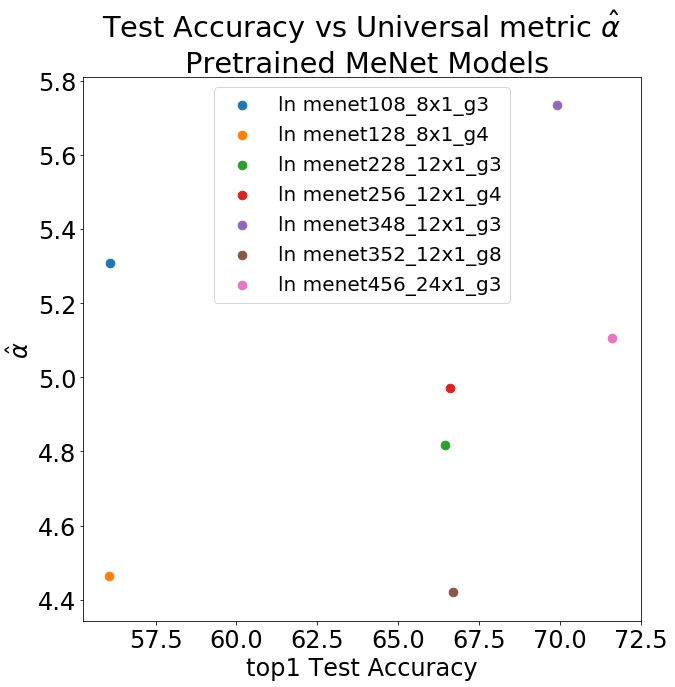

In [152]:
plot_top_errors(title="MeNet")

& resnet10 & 37.46 & 1.9442508762307031 \\
& resnet12 & 36.18 & 0.7435730322077716 \\
& resnet14 & 33.17 & 1.6989137427028054 \\
& resnet16 & 30.9 & 1.4948560192525948 \\
& resnet18\_wd4 & 49.5 & 1.8316095061540871 \\
& resnet18\_wd2 & 37.04 & 1.8209534054298246 \\
& resnet18\_w3d4 & 33.61 & 0.275197055094145 \\
& resnet18 & 29.52 & 1.0931776919464014 \\
& resnet34 & 25.66 & -0.4167435565963109 \\
& resnet50 & 23.79 & 0.12973522748591812 \\
& resnet50b & 23.05 & 0.0914701378854356 \\
& resnet101 & 21.9 & -0.6653172308894714 \\
& resnet101b & 21.45 & -0.9206956482884197 \\
& resnet152 & 21.26 & -1.107269622195169 \\
& resnet152b & 20.74 & -1.7448372455844239 \\


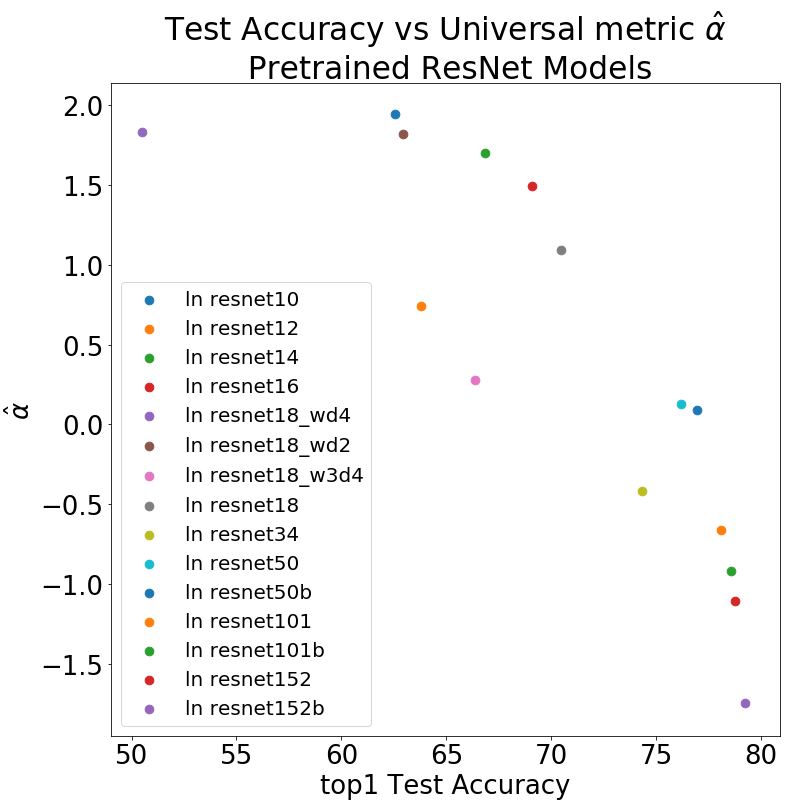

In [153]:
plt.rcParams['figure.figsize'] = [10,10]
plot_top_errors("ResNet", small=False)


### DPN

& dpn68 & 24.17 & 0.5671198123331914 \\
& dpn98 & 20.81 & 0.10859653346304365 \\
& dpn131 & 20.54 & -0.12574033092620057 \\


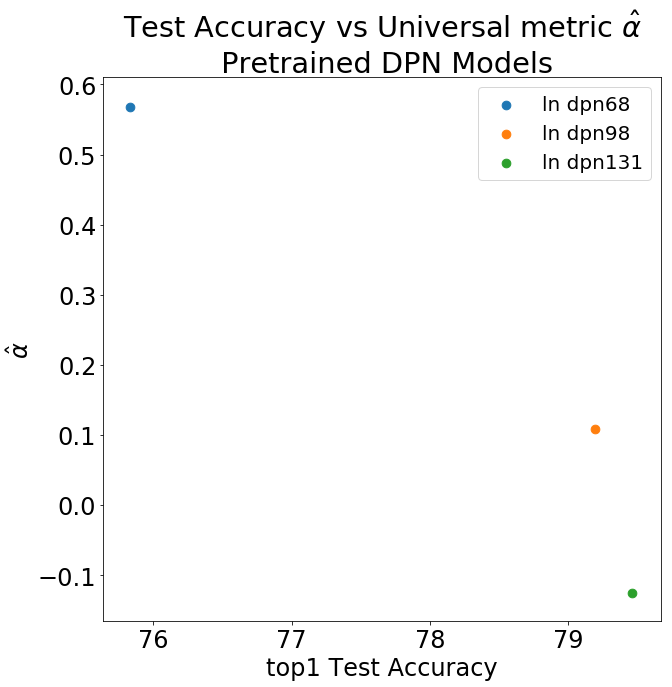

In [154]:
plot_top_errors("DPN")


### DenseNet

& densenet121 & 25.57 & 1.248707987388755 \\
& densenet161 & 22.86 & 0.838195490601221 \\
& densenet169 & 24.4 & 0.6786168956124697 \\
& densenet201 & 23.1 & 0.5016681704643254 \\


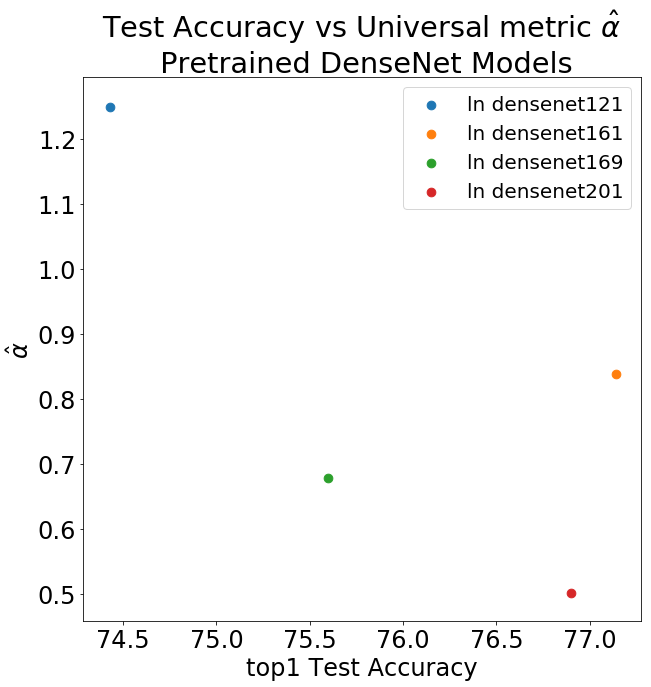

In [155]:
plot_top_errors("DenseNet")


### SeResNet

& seresnet50 & 22.47 & -0.3455397203741907 \\
& seresnet101 & 21.88 & -1.2371383409404113 \\
& seresnet152 & 21.48 & -1.5342404162449716 \\


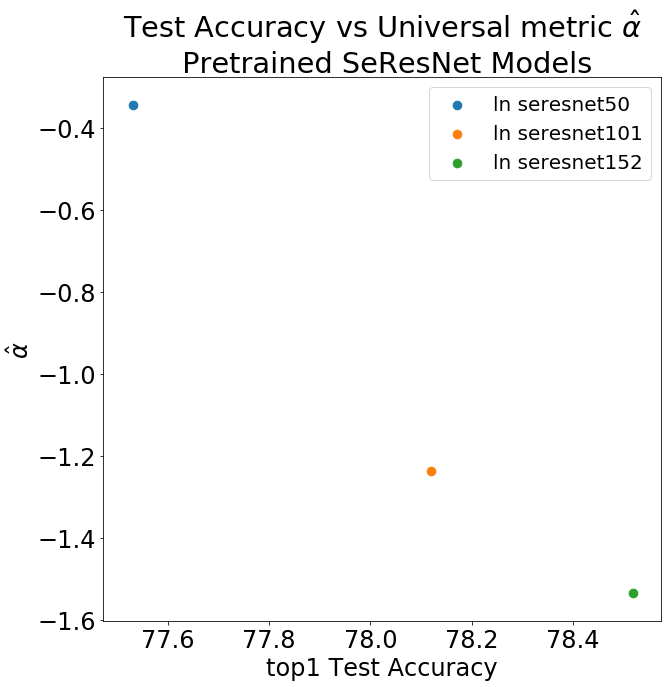

In [156]:
plot_top_errors("SeResNet")


### SeResNeXt

& seresnext50\_32x4d & 21.0 & 1.8067620396913677 \\
& seresnext101\_32x4d & 19.96 & 0.7584031176832214 \\


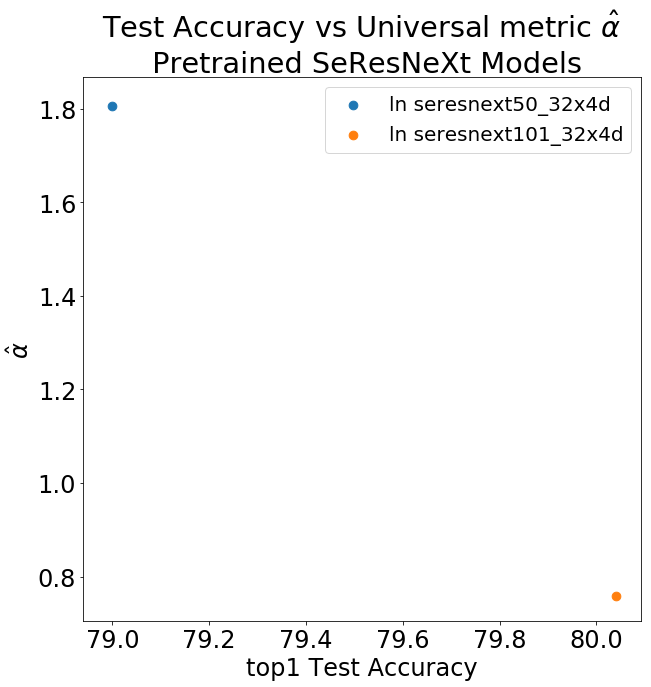

In [157]:
plot_top_errors("SeResNeXt")


& shufflenetv2\_wd2 & 41.48 & 5.1152540755298626 \\
& shufflenetv2\_w1 & 34.39 & 2.863452304186872 \\


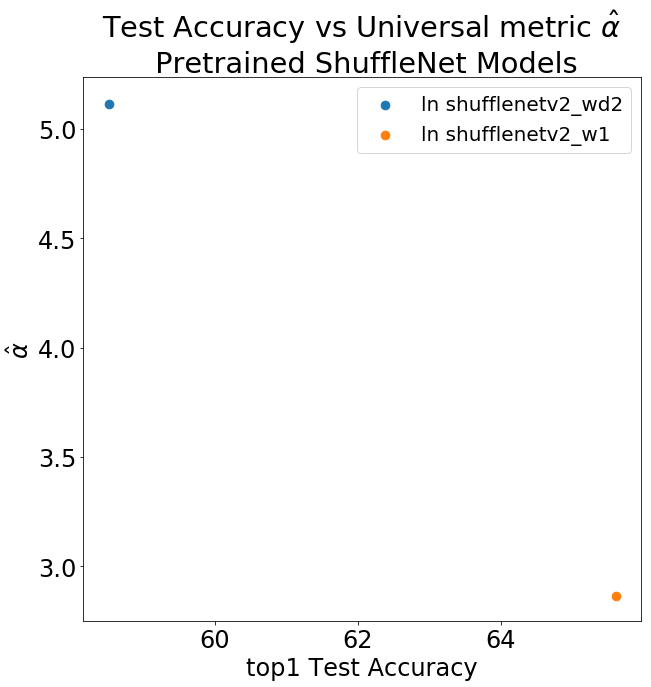

In [158]:
plot_top_errors("ShuffleNet")


## Counterexamples

- All 3 MobileNet models, which we may be interpreting incorrectly

- CondenseNet

- SqueezeNet, which different from the Pytorch defaults *(the numbers may be off)

& mobilenet\_wd4 & 46.26 & 5.543606824677111 \\
& mobilenet\_wd2 & 36.3 & 4.264810441406522 \\
& mobilenet\_w3d4 & 33.54 & 4.414959019154964 \\
& mobilenet\_w1 & 29.86 & 4.187408623053394 \\
& mobilenetv2\_wd4 & 49.72 & 12.120189843242203 \\
& mobilenetv2\_wd2 & 36.54 & 4.6901238612722125 \\
& mobilenetv2\_w3d4 & 31.89 & 4.205522477526878 \\
& mobilenetv2\_w1 & 29.31 & 3.5007829318466968 \\


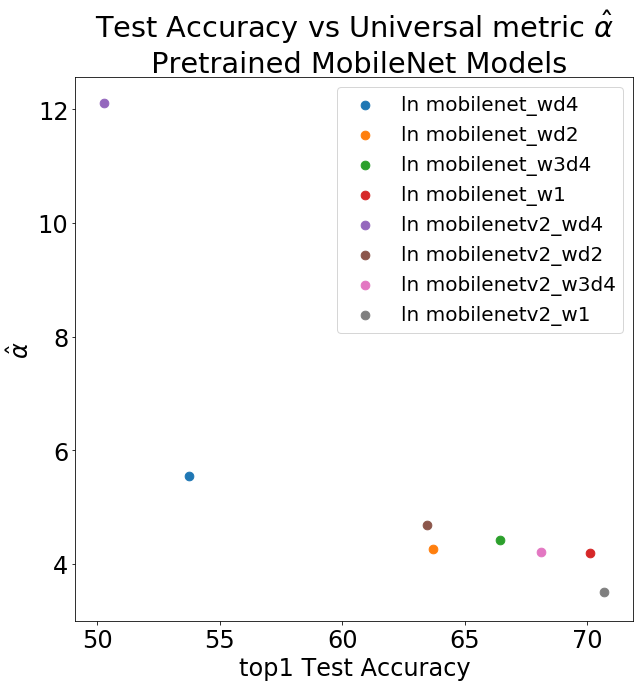

In [159]:
plot_top_errors("MobileNet")


& fdmobilenet\_wd4 & 55.77 & 6.403295564078693 \\
& fdmobilenet\_wd2 & 43.85 & 7.01239491498429 \\
& fdmobilenet\_w1 & 34.7 & 7.1034958239729695 \\


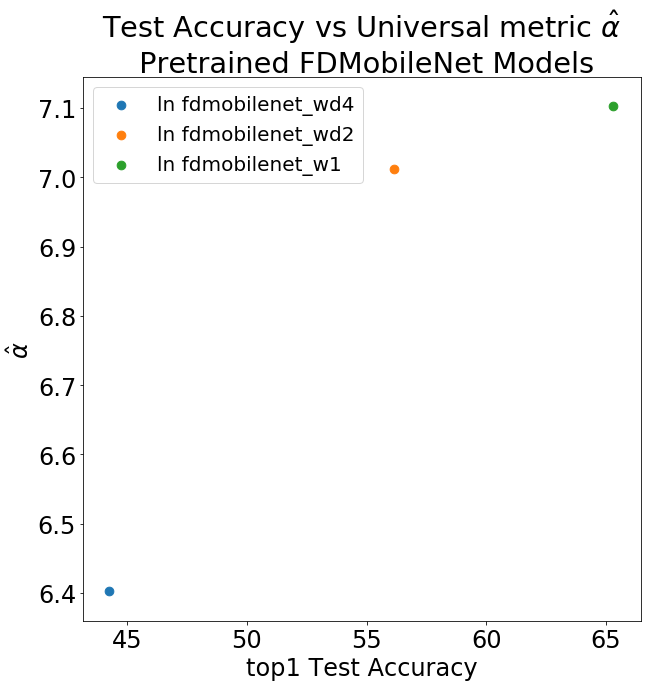

In [160]:
plot_top_errors("FDMobileNet")


###  CondenseNet is an outlier

& condensenet74\_c4\_g4 & 26.25 & -1.832024790934699 \\
& condensenet74\_c8\_g8 & 28.93 & -1.6294419980779795 \\


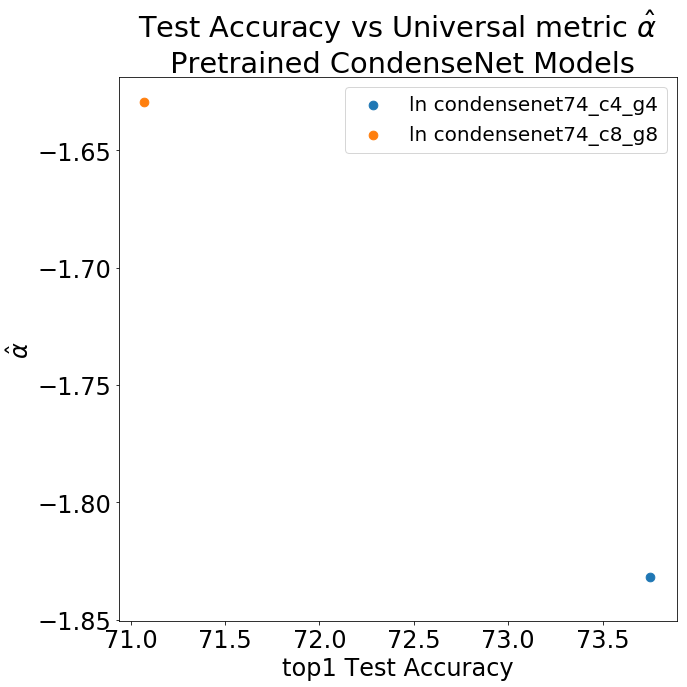

In [161]:
plot_top_errors(title="CondenseNet")


### ResNeXt

& resnext101\_32x4d & 21.81 & 1.2247421658391497 \\
& resnext101\_64x4d & 21.04 & 1.3415310024058 \\


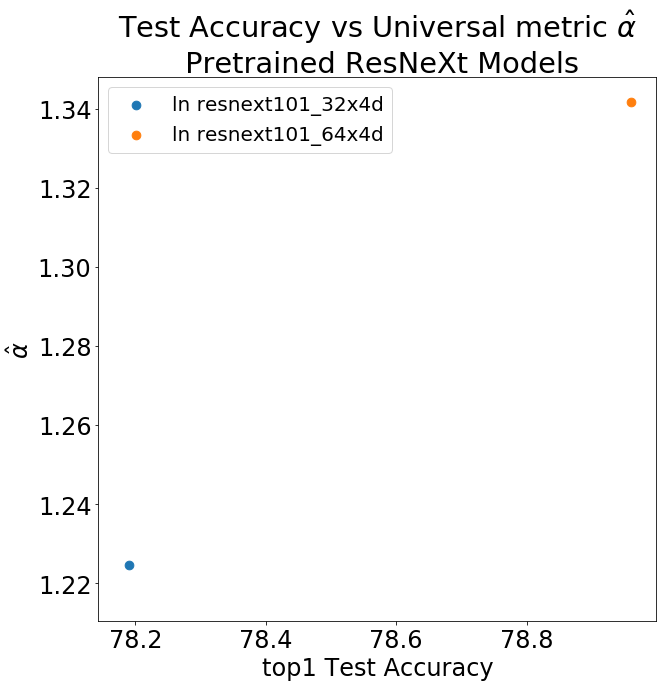

In [162]:
plot_top_errors("ResNeXt")


### Where is Inception ?

No handles with labels found to put in legend.


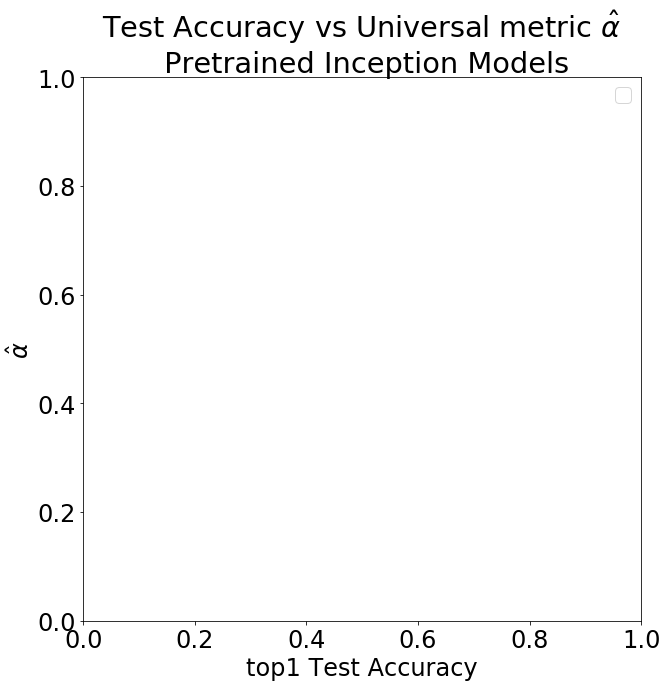

In [163]:
plot_top_errors("Inception")

In [164]:
!ls img/*w_a*

img/CondenseNet-w_alphas.png        img/SeResNeXt-w_alphas.png
img/DPN-w_alphas.png                img/SeResNet-w_alphas.png
img/DenseNet-w_alphas.png           img/ShuffleNet-w_alphas.png
img/FDMobileNet-w_alphas.png        img/densenet-pytorch-w_alphas.png
img/Inception-w_alphas.png          img/resnet-extended-w_alphas.png
img/MeNet-w_alphas.png              img/resnet-pytorch-w_alphas.png
img/MobileNet-w_alphas.png          img/squeezenet-pytorch-w_alphas.png
img/ResNeXt-w_alphas.png            img/vgg-w_alphas.png
img/ResNet-w_alphas.png
